## Stallman Problem

Stallman 1965 presents an analytical solution for transient heat flow
in the subsurface in response to a sinusoidally varying temperature
boundary imposed at the land surface, involving heat convection in
response to downward groundwater flow. The problem also includes
heat conduction through the fully saturated aquifer material. The
analytical solution quantifies the temperature variation as a function
of depth and time for this one-dimensional transient problem.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
example_name = "ex-gwt-stallman"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)
gif_save = get_env("GIF", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "seconds"

# Model parameters
nper = 600  # Number of periods
nstp = 6  # Number of time steps
perlen = 525600  # Simulation time length ($s$)
nlay = 120  # Number of layers
nrow = 1  # Number of rows
ncol = 1  # Number of columns
system_length = 60.0  # Length of system ($m$)
delr = 1.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
delv_str = "ranges from 0.1 to 1"  # Layer thickness
top = 60.0  # Top of the model ($m$)
hydraulic_conductivity = 1.0e-4  # Hydraulic conductivity ($m s^{-1}$)
porosity = 0.35  # Porosity (unitless)
alphal = 0.0  # Longitudinal dispersivity ($m$)
alphat = 0.0  # Transverse dispersivity ($m$)
diffc = 1.02882e-06  # Diffusion coefficient ($m s^{-1}$)
T_az = 10  # Ambient temperature ($^o C$)
dT = 5  # Temperature variation ($^o C$)
bulk_dens = 2630  # Bulk density ($kg/m^3$)
kd = 0.000191663  # Distribution coefficient (unitless)

# Stress period input
per_data = []
for k in range(nper):
    per_data.append((perlen, nstp, 1.0))
per_mf6 = per_data

# Geometry input
tp = top
botm = []
for i in range(nlay):
    if i == 0:
        botm.append(59.9)
    elif i == 119:
        botm.append(0.0)
    else:
        botm.append(60 - i * 0.5)

# Head input
chd_data = {}
for k in range(nper):
    chd_data[k] = [[(0, 0, 0), 60.000000], [(119, 0, 0), 59.701801]]
chd_mf6 = chd_data

# Initial temperature input
strt_conc = T_az * np.ones((nlay, 1, 1), dtype=np.float32)

# Boundary temperature input
cnc_data = {}
for k in range(nper):
    cnc_temp = T_az + dT * np.sin(2 * np.pi * k * perlen / 365 / 86400)
    cnc_data[k] = [[(0, 0, 0), cnc_temp]]
cnc_mf6 = cnc_data

nouter, ninner = 100, 300
hclose, rclose, relax = 1e-8, 1e-8, 0.97

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
# Analytical solution for Stallman analysis (Stallman 1965, JGR)
def Stallman(T_az, dT, tau, t, c_rho, darcy_flux, ko, c_w, rho_w, zbotm, nlay):
    zstallman = np.zeros((nlay, 2))
    K = np.pi * c_rho / ko / tau
    V = darcy_flux * c_w * rho_w / 2 / ko
    a = ((K**2 + V**4 / 4) ** 0.5 + V**2 / 2) ** 0.5 - V
    b = ((K**2 + V**4 / 4) ** 0.5 - V**2 / 2) ** 0.5
    for i in range(len(zstallman)):
        zstallman[i, 0] = zbotm[i]
        zstallman[i, 1] = (
            dT
            * np.exp(-a * (-zstallman[i, 0]))
            * np.sin(2 * np.pi * t / tau - b * (-zstallman[i, 0]))
            + T_az
        )
    return zstallman


def build_models(sim_folder):
    print(f"Building model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder)
    sim = flopy.mf6.MFSimulation(
        sim_name=name,
        sim_ws=sim_ws,
        exe_name="mf6",
    )
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=per_mf6, time_units=time_units)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    ims = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwf.name}.ims",
    )
    sim.register_ims_package(ims, [gwf.name])
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )

    flopy.mf6.ModflowGwfic(gwf, strt=top)

    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_mf6,
    )

    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    gwt = flopy.mf6.ModflowGwt(sim, modelname="trans")
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwt.name}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=porosity,
        sorption="linear",
        bulk_density=bulk_dens * (1 - porosity),
        distcoef=kd,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=strt_conc)
    flopy.mf6.ModflowGwtadv(gwt, scheme="TVD")
    flopy.mf6.ModflowGwtdsp(gwt, xt3d_off=True, alh=alphal, ath1=alphat, diffc=diffc)
    flopy.mf6.ModflowGwtssm(gwt, sources=[[]])
    flopy.mf6.ModflowGwtcnc(
        gwt,
        stress_period_data=cnc_mf6,
    )
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwt.name}.cbc",
        concentration_filerecord=f"{gwt.name}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("CONCENTRATION", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )
    flopy.mf6.ModflowGwfgwt(
        sim, exgtype="GWF6-GWT6", exgmnamea=gwf.name, exgmnameb=gwt.name
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 8)


def plot_conc(sim, idx):
    with styles.USGSMap() as fs:
        sim_name = example_name
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model("flow")
        gwt = sim.get_model("trans")

        # create MODFLOW 6 head object
        cobj = gwt.output.concentration()
        times = cobj.get_times()
        times = np.array(times)

        time_in_pub = 284349600.0
        idx_conc = (np.abs(times - time_in_pub)).argmin()
        time_this_plot = times[idx_conc]
        conc = cobj.get_data(totim=time_this_plot)

        zconc = np.zeros(nlay)
        zbotm = np.zeros(nlay)
        for i in range(len(zconc)):
            zconc[i] = conc[i][0][0]
            if i != (nlay - 1):
                zbotm[i + 1] = -(60 - botm[i])

        # Analytical solution - Stallman analysis
        tau = 365 * 86400
        # t =  283824000.0
        t = 284349600.0
        c_w = 4174
        rho_w = 1000
        c_r = 800
        rho_r = bulk_dens
        c_rho = c_r * rho_r * (1 - porosity) + c_w * rho_w * porosity
        darcy_flux = 5.00e-07
        ko = 1.503
        zanal = Stallman(
            T_az, dT, tau, t, c_rho, darcy_flux, ko, c_w, rho_w, zbotm, nlay
        )

        # make conc figure
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(1, 1, 1)

        # configure plot and save
        ax.plot(zconc, zbotm, "bo", mfc="none", label="MODFLOW6-GWT")
        ax.plot(
            zanal[:, 1],
            zanal[:, 0],
            "k--",
            linewidth=1.0,
            label="Analytical solution",
        )
        ax.set_xlim(T_az - dT, T_az + dT)
        ax.set_ylim(-top, 0)
        ax.set_ylabel("Depth (m)")
        ax.set_xlabel("Temperature (deg C)")
        ax.legend()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-conc.png"
            fig.savefig(fpth)


def make_animated_gif(sim, idx):
    sim_name = example_name
    sim_ws = os.path.join(workspace, sim_name)
    gwf = sim.get_model("flow")
    gwt = sim.get_model("trans")

    cobj = gwt.output.concentration()
    times = cobj.get_times()
    times = np.array(times)
    conc = cobj.get_alldata()

    zconc = np.zeros(nlay)
    zbotm = np.zeros(nlay)
    for i in range(len(zconc)):
        zconc[i] = conc[0][i][0][0]
        if i != (nlay - 1):
            zbotm[i + 1] = -(60 - botm[i])

    # Analytical solution - Stallman analysis
    tau = 365 * 86400
    t = times[0]
    c_w = 4174
    rho_w = 1000
    c_r = 800
    rho_r = bulk_dens
    c_rho = c_r * rho_r * (1 - porosity) + c_w * rho_w * porosity
    darcy_flux = 5.00e-07
    ko = 1.503
    zanal = Stallman(T_az, dT, tau, t, c_rho, darcy_flux, ko, c_w, rho_w, zbotm, nlay)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_ylabel("Depth (m)")
    ax.set_xlabel("Temperature (deg C)")
    (l0,) = ax.plot([], [], "bo", mfc="none", label="MODFLOW6-GWT")
    (l1,) = ax.plot([], [], "k--", linewidth=1.0, label="Analytical solution")
    line = [l0, l1]
    ax.legend(loc="lower left")
    ax.set_xlim(T_az - dT, T_az + dT)
    ax.set_ylim(-top, 0)

    def init():
        ax.set_title(f"Time = {times[0]} seconds")

    def update(j):
        for i in range(len(zconc)):
            zconc[i] = conc[j][i][0][0]
        t = times[j]
        zanal = Stallman(
            T_az, dT, tau, t, c_rho, darcy_flux, ko, c_w, rho_w, zbotm, nlay
        )
        line[0].set_data(zconc, zbotm)
        line[1].set_data(zanal[:, 1], zanal[:, 0])
        ax.set_title(f"Time = {times[j]} seconds")
        return line

    ani = animation.FuncAnimation(fig, update, times.shape[0], init_func=init)
    fpth = figs_path / "{}{}".format(sim_name, ".gif")
    ani.save(fpth, fps=50)


def plot_results(sim, idx):
    plot_conc(sim, idx)
    if plot_save and gif_save:
        make_animated_gif(sim, idx)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building model...ex-gwt-stallman


run_models took 12322.37 ms


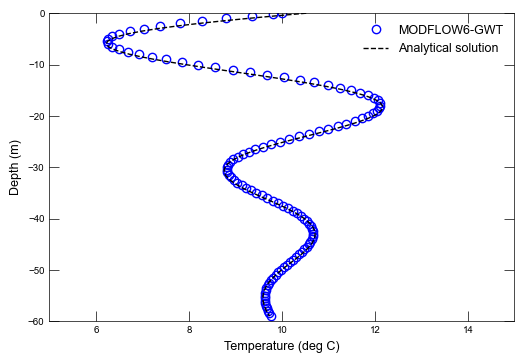

MovieWriter ffmpeg unavailable; using Pillow instead.


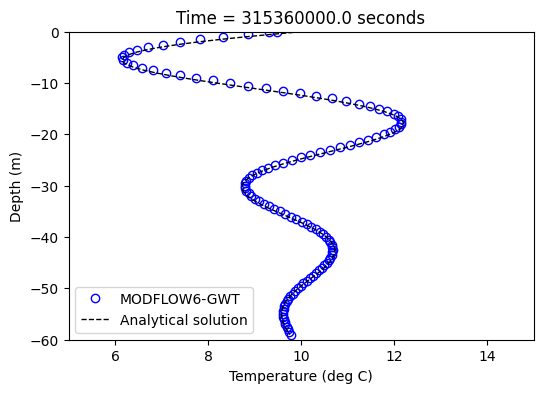

In [5]:
def scenario(idx, silent=True):
    sim = build_models(example_name)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, idx)


scenario(0)